In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
net = nn.Sequential(
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.LazyLinear(10)
)

In [3]:
net[0].weight

<UninitializedParameter>

In [4]:
X = torch.rand(2, 20)
net(X)

net[0].weight.shape

torch.Size([256, 20])

In [5]:
@d2l.add_to_class(d2l.Module)
def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
        self.net.apply(init)

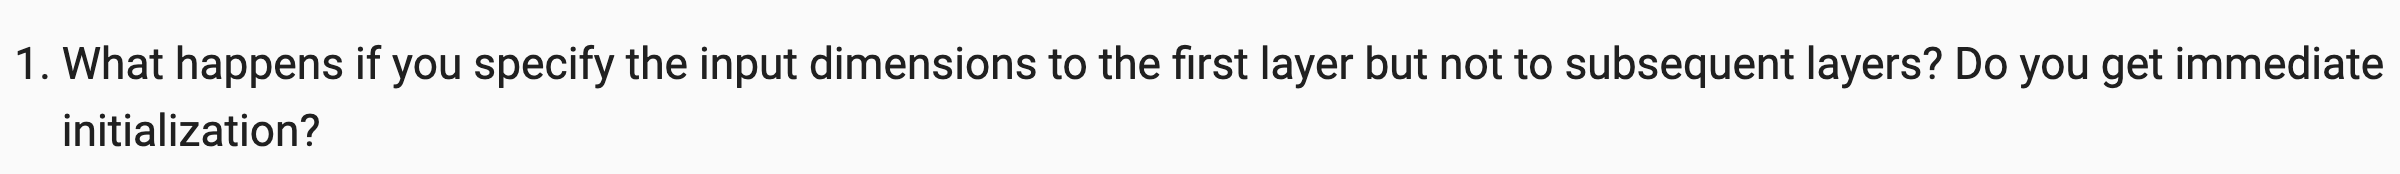

In [6]:
net = nn.Sequential(
    nn.Linear(10, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

In [7]:
net[0].weight

Parameter containing:
tensor([[ 0.2245,  0.2104,  0.1752,  ..., -0.0544,  0.2180, -0.1423],
        [-0.2231,  0.2381, -0.3016,  ...,  0.2960,  0.2889, -0.0709],
        [-0.1490,  0.1327, -0.0748,  ...,  0.1128,  0.1570, -0.2251],
        ...,
        [-0.0645, -0.0970, -0.0225,  ..., -0.2622, -0.1108, -0.2644],
        [ 0.2157,  0.2402, -0.2898,  ..., -0.1582, -0.0808, -0.0966],
        [ 0.2305, -0.2286, -0.0762,  ...,  0.1197, -0.2541, -0.2289]],
       requires_grad=True)

In [8]:
net = nn.Sequential(
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.LazyLinear(10)
)

In [9]:
net[0].weight

<UninitializedParameter>

In [10]:
net = nn.Sequential(
    nn.Linear(20, 256),
    nn.ReLU(),
    nn.LazyLinear(10)
)

In [11]:
net[0].weight

Parameter containing:
tensor([[ 0.0154,  0.1786, -0.1294,  ..., -0.0449,  0.0680,  0.1717],
        [ 0.1798,  0.1811, -0.0808,  ..., -0.1219, -0.2182,  0.0549],
        [ 0.1021,  0.1806,  0.0665,  ...,  0.2023,  0.0400, -0.1081],
        ...,
        [ 0.0569, -0.1285,  0.1947,  ...,  0.0229, -0.1727, -0.1165],
        [-0.1955,  0.0629,  0.1826,  ...,  0.1357,  0.0446,  0.1125],
        [-0.1305, -0.1448,  0.1378,  ..., -0.0645, -0.0374,  0.0729]],
       requires_grad=True)

In [12]:
net[2].weight

<UninitializedParameter>

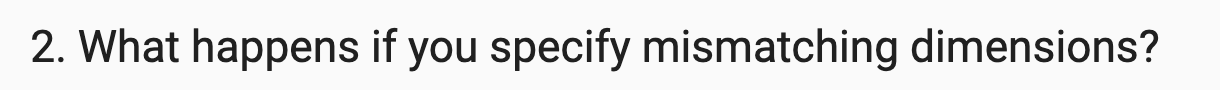

In [13]:
net = nn.Sequential(
    nn.Linear(20, 256),
    nn.ReLU(),
    nn.Linear(250, 10)
)

In [14]:
net(X)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x256 and 250x10)

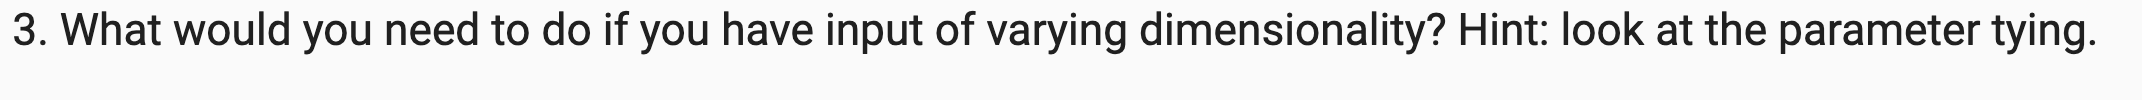

In [18]:
class TyingParametersMLP(d2l.Classifier):
    def __init__(self, num_inputs, num_hiddens, num_outputs):
        super().__init__()
        self.save_hyperparameters()
        self.shared = nn.Linear(num_inputs, num_hiddens[0])

        layers = [nn.ReLU()]
        for i in range(1, len(self.num_hiddens)):
            layers.append(nn.Linear(num_hiddens[i - 1], num_hiddens[i]))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(num_hiddens[-1], num_outputs))
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        if X.shape[-1] < self.num_inputs:
            pad = self.num_inputs - X.shape[-1]
            zeros = torch.zeros((X.shape[0], pad))
            X = torch.cat([X, zeros], dim=1)
            k = 1
        else:
            k = (self.num_inputs + X.shape[-1] - 1) // self.num_inputs
            pad = k * self.num_inputs - X.shape[-1]

            if pad != 0:
                zeros = torch.zeros((X.shape[0], pad))
                X = torch.cat([X, zeros], dim=1)

        acc_X = self.shared(X[:, 0:self.num_inputs])

        for i in range(1, k):
            acc_X += self.shared(X[:, self.num_inputs * i : self.num_inputs * (i + 1)])
        
        return self.net(acc_X)

In [21]:
hparams = {
    "num_inputs": 28,
    "num_hiddens": [56, 112, 224, 112, 56, 28],
    "num_outputs": 10
} 

model = TyingParametersMLP(**hparams)

In [25]:
X1 = torch.randn(20, 28)
model(X1).shape

torch.Size([20, 10])

In [26]:
X2 = torch.randn(20, 13)
model(X2).shape

torch.Size([20, 10])

In [27]:
X2 = torch.randn(20, 45)
model(X2).shape

torch.Size([20, 10])